# Project4 - Deep Lerning

## Image Classification


---
## 데이터 설명 - Stanford Cars Dataset (1.85 GB)

http://ai.stanford.edu/~jkrause/cars/car_dataset.html

196 class의 (차종)

8,144 개의 train 이미지 

8,041 개의 test 이미지

총 16,185 개의 이미지로 구성


* 

주어진 데이터는 바운딩 박스의 좌표 데이터도 함께 주어졌다. 따라서 전처리로 선행되어야 할 바운딩 처리는 생략하고 진행한다.

---

##Data set 정보
- train.csv - Train 셋의 이미지 파일명, 바운딩박스 좌표, 차종정보
- test.csv - Test 셋의 이미지 파일명, 바운딩박스 좌표, 차종정보
- class.csv - 데이터 셋의 class 컬럼과 대응되는 차종의 레이블
- train - Train 이미지 파일
- test - Test 이미지 파일

---

## 목표 

1. 이미지에서 자동차 인식

2. 구분된 자동차의 차종 분류 예측  
   (test 의 class 가 target이 된다.)

---


In [65]:
import os
import gc
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [66]:
# ## 드라이브 마운트

# from google.colab import drive
# drive.mount('/content/drive/')

### 파일 로드 및 확인

In [67]:
DATA_PATH = 'E:/coding/Stanford Cars Dataset/car_data/car_data'
os.listdir(DATA_PATH)

['class.csv',
 'sample_submission.csv',
 'sample_submission2.csv',
 'test',
 'test.csv',
 'test_crop',
 'test_crop.zip',
 'test_dj',
 'test_dj.csv',
 'test_폴더',
 'train',
 'train.csv',
 'train_crop',
 'train_crop.zip',
 'train_폴더']

In [68]:
# 이미지 폴더 경로
TRAIN_IMG_PATH = os.path.join(DATA_PATH, 'train')
TEST_IMG_PATH = os.path.join(DATA_PATH, 'test')

# CSV 파일 경로
df_train = pd.read_csv(os.path.join(DATA_PATH, 'train.csv'))
df_test = pd.read_csv(os.path.join(DATA_PATH, 'test.csv'))
df_class = pd.read_csv(os.path.join(DATA_PATH, 'class.csv'))

# IMG_SIZE
IMG_SIZE = (224, 224)

In [69]:
df_train.head()

,img_file,bbox_x1,bbox_y1,bbox_x2,bbox_y2,class
0,00001.jpg,39,116,569,375,14
1,00002.jpg,36,116,868,587,3
2,00003.jpg,85,109,601,381,91
3,00004.jpg,621,393,1484,1096,134
4,00005.jpg,14,36,133,99,106


In [70]:
df_test.head()

,img_file,bbox_x1,bbox_y1,bbox_x2,bbox_y2
0,00001.jpg,30,52,246,147
1,00002.jpg,100,19,576,203
2,00003.jpg,51,105,968,659
3,00004.jpg,67,84,581,407
4,00005.jpg,140,151,593,339


In [71]:
df_class.head()

,id,name
0,1,AM General Hummer SUV 2000
1,2,Acura RL Sedan 2012
2,3,Acura TL Sedan 2012
3,4,Acura TL Type-S 2008
4,5,Acura TSX Sedan 2012


In [72]:
df_class[df_class['id'] == 32]

,id,name
31,32,BMW X5 SUV 2007


In [73]:
# Data 누락 체크
if set(list(df_train.img_file)) == set(os.listdir(TRAIN_IMG_PATH)) :
    print("Train file 누락 없음!")
else : 
    print("Train file 누락")

if set(list(df_test.img_file)) == set(os.listdir(TEST_IMG_PATH)) :
    print("Test file 누락 없음!")
else : 
    print("Test file 누락")

Train file 누락 없음!
Test file 누락 없음!


## 파일 실제 확인

In [74]:
## 파일 총 길이 체크 (test = 8041)
len(os.listdir(TEST_IMG_PATH))

8041

In [75]:
## 파일 총 길이 체크 (train = 8144)
len(os.listdir(TRAIN_IMG_PATH))

8144

In [76]:
## class 종류 
len(df_class)

196

In [77]:
## train 파일의 class 종류 
df_train['class'].nunique()

196

In [78]:
# ## 파일 업로드 오류 찾기 (test)
# a1 = os.listdir(TEST_IMG_PATH)

# for i in range(0,8100):
#     a1.sort()
#     if int(a1[i][0:5]) == i+1:
#         pass
#     else:
#         print(i,int(a1[i][0:5]),'Flas')
#         break

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


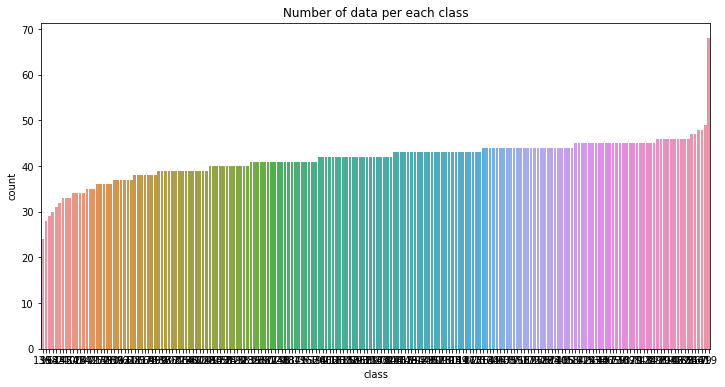

In [79]:
## 클래스 분포 확인

plt.figure(figsize=(12, 6))
sns.countplot(df_train["class"], order=df_train["class"].value_counts(ascending=True).index)
plt.title("Number of data per each class")
plt.show()

## 이미지 확인

In [80]:
import PIL
from PIL import ImageDraw

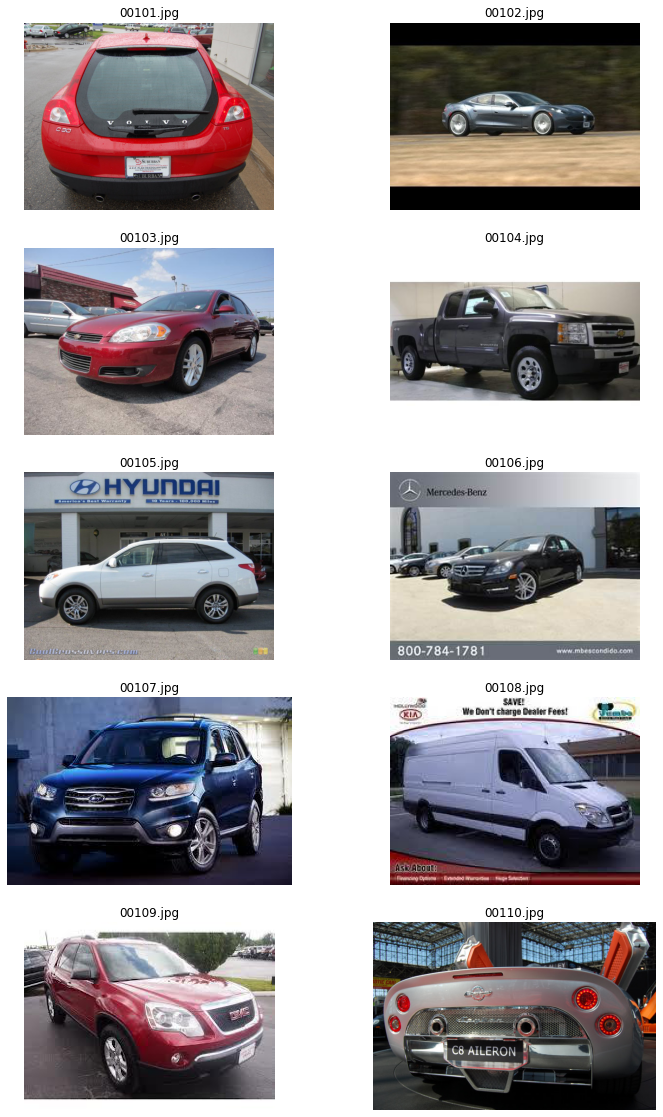

In [81]:
tmp_imgs = df_train['img_file'][100:110]
plt.figure(figsize=(12,20))

for num, f_name in enumerate(tmp_imgs):
    img = PIL.Image.open(os.path.join(TRAIN_IMG_PATH, f_name))
    plt.subplot(5, 2, num + 1)
    plt.title(f_name)
    plt.imshow(img)
    plt.axis('off')

In [82]:
## 박스 처리

def draw_rect(drawcontext, pos, outline=None, width=0):
    (x1, y1) = (pos[0], pos[1])
    (x2, y2) = (pos[2], pos[3])
    points = (x1, y1), (x2, y1), (x2, y2), (x1, y2), (x1, y1)
    drawcontext.line(points, fill=outline, width=width)

In [83]:
## train data 바운딩 처리

def make_boxing_img_train(img_name) :
    PATH = TRAIN_IMG_PATH
    data = df_train

    img = PIL.Image.open(os.path.join(PATH, img_name))
    pos = data.loc[data["img_file"] == img_name, \
                   ['bbox_x1','bbox_y1', 'bbox_x2', 'bbox_y2']].values.reshape(-1)
    draw = ImageDraw.Draw(img)
    draw_rect(draw, pos, outline='red', width=10)
    
    return img

In [84]:
## test data 바운딩 처리

def make_boxing_img_test(img_name) :
    PATH = TEST_IMG_PATH
    data = df_test

    img = PIL.Image.open(os.path.join(PATH, img_name))
    pos = data.loc[data["img_file"] == img_name, \
                   ['bbox_x1','bbox_y1', 'bbox_x2', 'bbox_y2']].values.reshape(-1)
    draw = ImageDraw.Draw(img)
    draw_rect(draw, pos, outline='red', width=10)
    
    return img

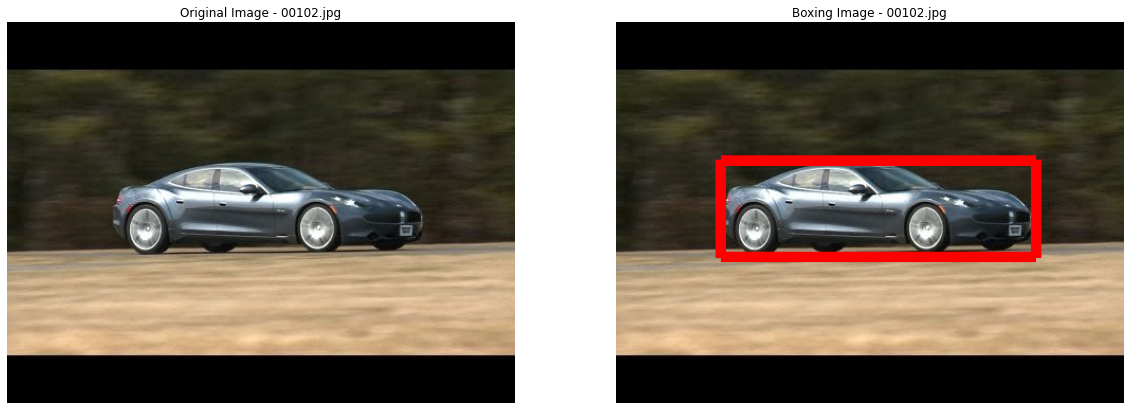

In [85]:
## 확인하고 싶은 이미지 번호 입력
f_name = "00102.jpg"

plt.figure(figsize=(20,10))

## 원본 이미지
plt.subplot(1, 2, 1)
origin_img = PIL.Image.open(os.path.join(TRAIN_IMG_PATH, f_name))
plt.title("Original Image - {}".format(f_name))
plt.imshow(origin_img)
plt.axis('off')

## Bounding Box 처리 된 이미지
plt.subplot(1, 2, 2)
boxing = make_boxing_img_train(f_name)
plt.title("Boxing Image - {}".format(f_name))
plt.imshow(boxing)
plt.axis('off')

plt.show()

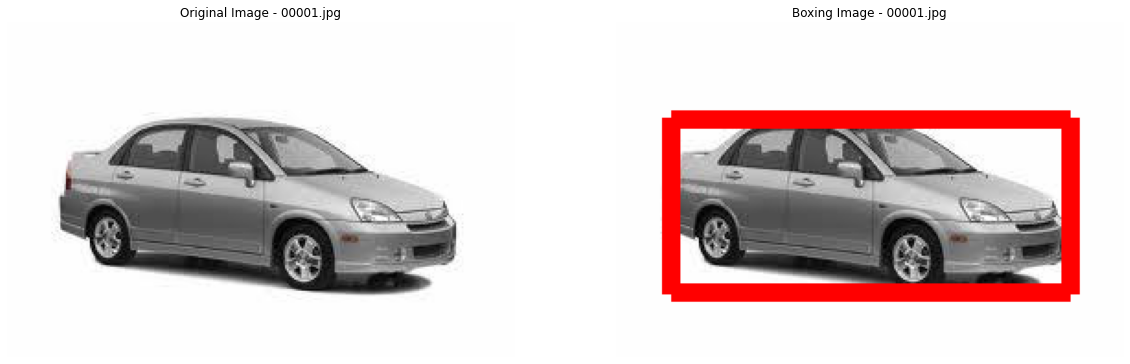

In [86]:
## 확인하고 싶은 이미지 번호 입력
f_name = "00001.jpg"

plt.figure(figsize=(20,10))

## 원본 이미지
plt.subplot(1, 2, 1)
origin_img = PIL.Image.open(os.path.join(TEST_IMG_PATH, f_name))
plt.title("Original Image - {}".format(f_name))
plt.imshow(origin_img)
plt.axis('off')

## Bounding Box 처리 된 이미지
plt.subplot(1, 2, 2)
boxing = make_boxing_img_test(f_name)
plt.title("Boxing Image - {}".format(f_name))
plt.imshow(boxing)
plt.axis('off')

plt.show()

## 이미지 resize 하기

In [87]:
## train 이미지 resize

def crop_resize_boxing_img_train(img_name, margin=16, size=(224, 224)) :
    PATH = TRAIN_IMG_PATH
    data = df_train
        
    img = PIL.Image.open(os.path.join(PATH, img_name))
    pos = data.loc[data["img_file"] == img_name, \
                   ['bbox_x1','bbox_y1', 'bbox_x2', 'bbox_y2']].values.reshape(-1)

    width, height = img.size
    x1 = max(0, pos[0] - margin)
    y1 = max(0, pos[1] - margin)
    x2 = min(pos[2] + margin, width)
    y2 = min(pos[3] + margin, height)

    return img.crop((x1,y1,x2,y2)).resize(size)

In [88]:
## test 이미지 resize

def crop_resize_boxing_img_test(img_name, margin=16, size=IMG_SIZE) :
    PATH = TEST_IMG_PATH
    data = df_test
        
    img = PIL.Image.open(os.path.join(PATH, img_name))
    pos = data.loc[data["img_file"] == img_name, \
                   ['bbox_x1','bbox_y1', 'bbox_x2', 'bbox_y2']].values.reshape(-1)

    width, height = img.size
    x1 = max(0, pos[0] - margin)
    y1 = max(0, pos[1] - margin)
    x2 = min(pos[2] + margin, width)
    y2 = min(pos[3] + margin, height)

    return img.crop((x1,y1,x2,y2)).resize(size)

In [89]:
# %%time
# ## 박스에 맞춰 이미지 resize (train data) 후 폴더에 저장

# for i, row in df_train.iterrows():
#     cropped = crop_resize_boxing_img_train(row['img_file'])
#     cropped.save(f"{'E:/coding/Stanford Cars Dataset/car_data/car_data/train_crop'}/{row['img_file']}")

In [90]:
# %%time
# ## 박스에 맞춰 이미지 resize (test data) 후 폴더에 저장

# for i, row in df_test.iterrows():
#     cropped = crop_resize_boxing_img_test(row['img_file'])
#     cropped.save(f"{'E:/coding/Stanford Cars Dataset/car_data/car_data/test_crop'}/{row['img_file']}")

In [91]:
## crop 이미지 경로 설정

TRAIN_CROP_PATH = os.path.join(DATA_PATH, 'train_crop')
TEST_CROP_PATH = os.path.join(DATA_PATH, 'test_crop')

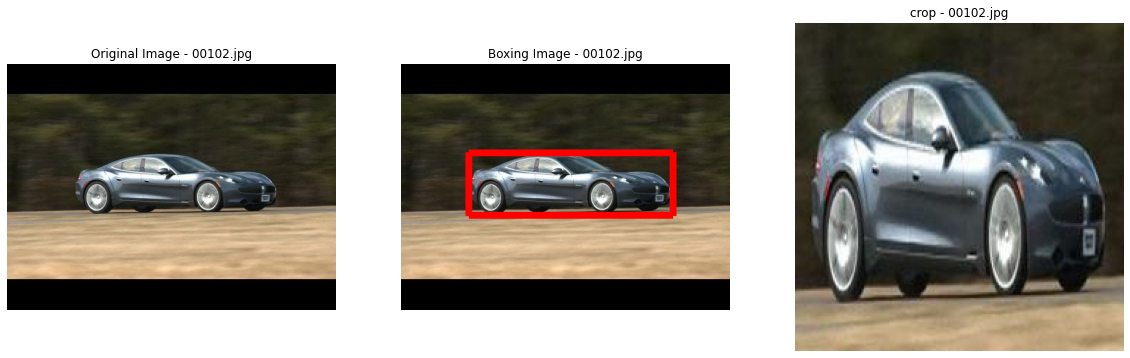

In [92]:
## 확인하고 싶은 이미지 번호 입력
f_name = "00102.jpg"

plt.figure(figsize=(20,10))

## 원본 이미지
plt.subplot(1, 3, 1)
origin_img = PIL.Image.open(os.path.join(TRAIN_IMG_PATH, f_name))
plt.title("Original Image - {}".format(f_name))
plt.imshow(origin_img)
plt.axis('off')

## Bounding Box 처리 된 이미지
plt.subplot(1, 3, 2)
boxing = make_boxing_img_train(f_name)
plt.title("Boxing Image - {}".format(f_name))
plt.imshow(boxing)
plt.axis('off')

## crop 된 이미지
plt.subplot(1, 3, 3)
crop = PIL.Image.open(os.path.join(TRAIN_CROP_PATH, f_name))
plt.title("crop - {}".format(f_name))
plt.imshow(crop)
plt.axis('off')

plt.show()

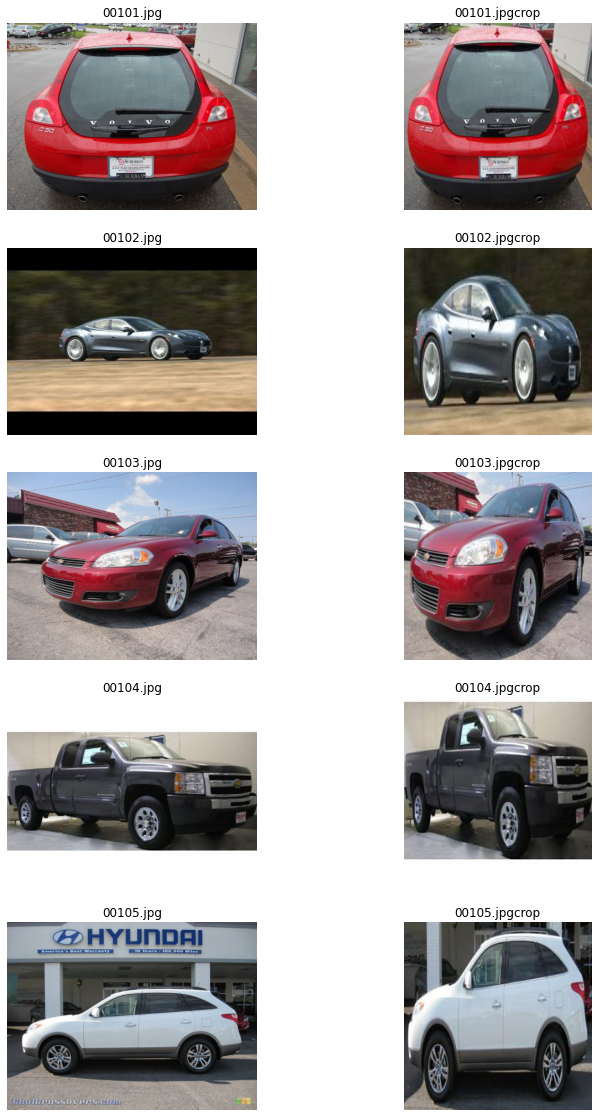

In [93]:
## crop 된 이미지 확인

tmp_imgs = df_train['img_file'][100:105]
plt.figure(figsize=(12,20))

for num, f_name in enumerate(tmp_imgs):
    img = PIL.Image.open(os.path.join(TRAIN_IMG_PATH, f_name))
    plt.subplot(5, 2, 2*num + 1)
    plt.title(f_name)
    plt.imshow(img)
    plt.axis('off')
    
    img = PIL.Image.open(os.path.join(TRAIN_CROP_PATH, f_name))
    plt.subplot(5, 2, 2*num + 2)
    plt.title(f_name + "crop")
    plt.imshow(img)
    plt.axis('off')

## 모델링

In [94]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8144 entries, 0 to 8143
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   img_file  8144 non-null   object
 1   bbox_x1   8144 non-null   int64 
 2   bbox_y1   8144 non-null   int64 
 3   bbox_x2   8144 non-null   int64 
 4   bbox_y2   8144 non-null   int64 
 5   class     8144 non-null   int64 
dtypes: int64(5), object(1)
memory usage: 381.9+ KB


In [95]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8041 entries, 0 to 8040
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   img_file  8041 non-null   object
 1   bbox_x1   8041 non-null   int64 
 2   bbox_y1   8041 non-null   int64 
 3   bbox_x2   8041 non-null   int64 
 4   bbox_y2   8041 non-null   int64 
dtypes: int64(4), object(1)
memory usage: 314.2+ KB


In [96]:
## train, val, test set 나눠주기

from sklearn.model_selection import train_test_split

## class 를 string 으로 바꿔주고 좌표들을 지워준다.
df_train["class"] = df_train["class"].astype('str')

df_train = df_train[['img_file', 'class']]
df_test = df_test[['img_file']]

its = np.arange(df_train.shape[0])
train_idx, val_idx = train_test_split(its, train_size = 0.8, random_state=42)

X_train = df_train.iloc[train_idx, :]
X_val = df_train.iloc[val_idx, :]

print(X_train.shape)
print(X_val.shape)
print(df_test.shape)

(6515, 2)
(1629, 2)
(8041, 1)


모델링은 keras의 generator 들을 이용하면 쉽게 만들 수 있다.

In [97]:
import tensorflow as tf
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [98]:
## 데이터 제네레이터 구성하기

## 파라미터 설정
## https://keras.io/api/preprocessing/image/

img_size = (224, 224)
nb_train_samples = len(X_train)
nb_validation_samples = len(X_val)
nb_test_samples = len(df_test)
epochs = 20
batch_size = 32

## 입력이미지의 데이터 증강 (Data Augmentation)
train_datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.1,
    fill_mode='nearest',
    preprocessing_function=preprocess_input
)
# val_datagen = ImageDataGenerator()
# test_datagen = ImageDataGenerator()

val_datagen = ImageDataGenerator(rescale=1. / 255)
test_datagen = ImageDataGenerator(rescale=1. / 255)

In [99]:
## 제네레이터 설정
##.flow_from_dataframe
##.flow_from_directory

train_generator = train_datagen.flow_from_dataframe(
    dataframe=X_train, 
    directory=TRAIN_CROP_PATH,
    x_col = 'img_file',
    y_col = 'class',
    target_size = img_size,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    seed=2000
)

validation_generator = val_datagen.flow_from_dataframe(
    dataframe=X_val, 
    directory=TRAIN_CROP_PATH,
    x_col='img_file',
    y_col='class',
    target_size=img_size,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    seed=2000
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=df_test,
    directory=TEST_CROP_PATH,
    x_col='img_file',
    y_col=None,
    target_size= img_size,
    color_mode='rgb',
    class_mode=None,
    batch_size=batch_size,
    shuffle=False
)

Found 6515 validated image filenames belonging to 196 classes.
Found 1629 validated image filenames belonging to 196 classes.
Found 8041 validated image filenames.


In [100]:
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, Conv2D, GlobalAveragePooling2D
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [108]:

## MobileNet 으로  base model을 만든다.

# weights='imagenet' : 이미지 넷에 트레이닝 된 모델을 불러옴

IMG_SHAPE = IMG_SIZE + (3, )

BaseModel = MobileNet(weights='imagenet', include_top=False, input_shape = IMG_SHAPE)

model = Sequential()
model.add(BaseModel)
model.add(GlobalAveragePooling2D())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(196, activation='softmax'))
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Function (None, 7, 7, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d_4 ( (None, 1024)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 196)               200900    
Total params: 4,479,364
Trainable params: 4,457,476
Non-trainable params: 21,888
_________________________________________________________________


In [109]:
## 모델 컴파일 하기

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

In [110]:
## 모델을 저장할 폴더와 경로 지정 (Best 모델 저장)

model_path = '../model/'
if not os.path.exists(model_path):
    os.mkdir(model_path)
    
model_path = model_path + 'best_model.hdf5'

In [111]:
## 콜백 지정

patient = 2
callbacks1 = [
    EarlyStopping(monitor='val_loss', patience=patient, mode='min', verbose=1),
    ReduceLROnPlateau(monitor = 'val_loss', factor = 0.5, patience = patient / 2, min_lr=0.00001, verbose=1, mode='min'),
    ModelCheckpoint(filepath=model_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min'),
    ]

In [112]:
def get_steps(num_samples, batch_size):
    if (num_samples % batch_size) > 0 :
        return (num_samples // batch_size) + 1
    else :
        return num_samples // batch_size

In [94]:
## 모델 학습

## 곡선을 그리기 위해 history

history = model.fit_generator(
    train_generator,
    steps_per_epoch=get_steps(nb_train_samples, batch_size),
    epochs=100,
    validation_data=validation_generator,
    validation_steps=get_steps(nb_validation_samples, batch_size),
    verbose=1,
    callbacks = callbacks1
)

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1935: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
204/204 [==============================] - 55s 261ms/step - loss: 4.9176 - acc: 0.0401 - val_loss: 5.1971 - val_acc: 0.0289

Epoch 00001: val_loss improved from inf to 5.19705, saving model to ../model\best_model.hdf5
Epoch 2/100
204/204 [==============================] - 53s 257ms/step - loss: 3.4434 - acc: 0.1724 - val_loss: 3.6839 - val_acc: 0.1381

Epoch 00002: val_loss improved from 5.19705 to 3.68387, saving model to ../model\best_model.hdf5
Epoch 3/100
204/204 [==============================] - 53s 259ms/step - loss: 2.3580 - acc: 0.3546 - val_loss: 3.0579 - val_acc: 0.2234

Epoch 00003: val_loss improved from 3.68387 to 3.05791, saving model to ../model\best_model.hdf5
Epoch 4/100
204/204 [==============================] - 53s 261ms/step - loss: 1.6973 - acc: 0.5088 - val_loss: 2.7162 - val_acc: 0.3382

Epoch 00004: val_loss improved from 3.05791 to 2.71618, saving model to ../model\best_model.hdf5
Epoch 5/100
204/204 [==============================] - 53s 260ms/ste

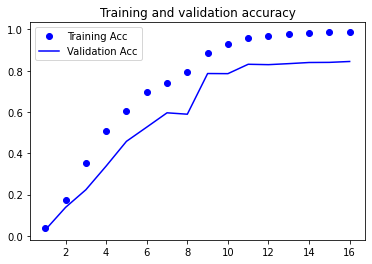

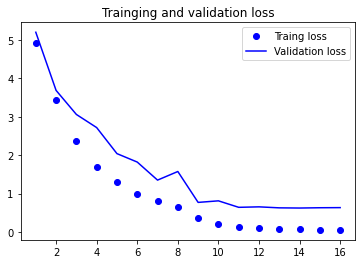

In [95]:
## 트레이닝 결과 곡선

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

## validation acc 곡선 그래프
plt.plot(epochs, acc, 'bo', label='Training Acc')
plt.plot(epochs, val_acc, 'b', label='Validation Acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

## validation loss 곡선 그래프
plt.plot(epochs, loss, 'bo', label='Traing loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Trainging and validation loss')
plt.legend()
plt.show()

In [113]:
## Bset model 을 불러와 적용하기

model.load_weights(model_path)
test_generator.reset()

prediction = model.predict_generator(
    generator=test_generator,
    steps = get_steps(nb_test_samples, batch_size),
    verbose=1
)

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1996: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


252/252 [==============================] - 34s 136ms/step


In [115]:
predicted_class_indices=np.argmax(prediction, axis=1)

# Generator class dictionary mapping
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

submission = pd.read_csv(os.path.join(DATA_PATH, 'sample_submission.csv'))
submission["class"] = predictions
submission.to_csv("submission.csv", index=False)
submission.head()

,img_file,class
0,00001.jpg,181
1,00002.jpg,103
2,00003.jpg,145
3,00004.jpg,187
4,00005.jpg,185


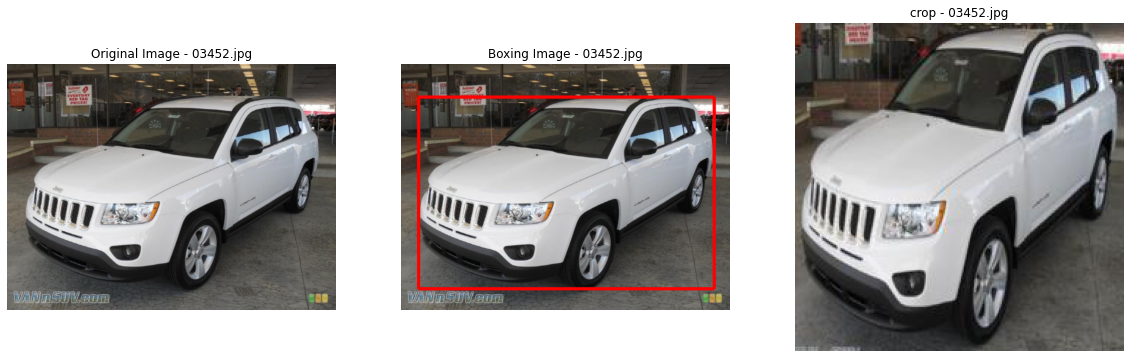

In [50]:
## test 이미지 확인
f_name = "03452.jpg"

plt.figure(figsize=(20,10))

## 원본 이미지
plt.subplot(1, 3, 1)
origin_img = PIL.Image.open(os.path.join(TEST_IMG_PATH, f_name))
plt.title("Original Image - {}".format(f_name))
plt.imshow(origin_img)
plt.axis('off')

## Bounding Box 처리 된 이미지
plt.subplot(1, 3, 2)
boxing = make_boxing_img_test(f_name)
plt.title("Boxing Image - {}".format(f_name))
plt.imshow(boxing)
plt.axis('off')

## crop 된 이미지
plt.subplot(1, 3, 3)
crop = PIL.Image.open(os.path.join(TEST_CROP_PATH, f_name))
plt.title("crop - {}".format(f_name))
plt.imshow(crop)
plt.axis('off')

plt.show()

In [120]:
## 분류한 이미지의 추정 class 와 모델
## id = 추정 class 
## name 추정 모델 명

as1 = submission[submission['img_file'] == f_name]
df_class[df_class['id'] == int(as1.iloc[0][1])]

,id,name
148,149,Jeep Compass SUV 2012


In [52]:
as1

,img_file,class
3451,03452.jpg,149


# 간략 평가

In [117]:
EVAL_PATH = 'E:/coding/Stanford Cars Dataset'

all100 = pd.read_csv(os.path.join(EVAL_PATH, 'test_class.csv'))
all100 = all100[['img_file', 'class']]

In [121]:
score = []
for i in range(0,8040):
    if int(all100['class'][i]) == int(submission['class'][i]) :
        score.append(1)
    else:
        score.append(0)
print('정확도 : ' , score.count(1)/8040)
print('맞은 갯수 : ' , score.count(1), ' / 8040')
print('안맞은 갯수 : ',score.count(0))

정확도 :  0.8318407960199005
맞은 갯수 :  6688  / 8040
안맞은 갯수 :  1352


---
---
---
추가로 직쩝 찍은 사진과, 국내 중고차 사진을 라벨링하여 모델에 돌려 보았다 시간 관계상 작은 숫자의 샘플밖에 실행하지 못하였다.

실제로 돌려작업을 해보려 하였다


## 추가 파일 확인

In [122]:
N_TEST = os.path.join(DATA_PATH, 'test_dj')
n_test = pd.read_csv(os.path.join(DATA_PATH, 'test_dj.csv'))

In [123]:
n_test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [124]:
nb_n_test_samples = len(n_test)

In [125]:
n_test_generator = n_test_datagen.flow_from_dataframe(
    dataframe=n_test,
    directory=N_TEST,
    x_col='img_file',
    y_col=None,
    target_size= img_size,
    color_mode='rgb',
    class_mode=None,
    batch_size=batch_size,
    shuffle=False
)

Found 57 validated image filenames.


In [126]:
## Bset model 을 불러와 적용하기

model.load_weights(model_path)
n_test_generator.reset()

prediction = model.predict_generator(
    generator=n_test_generator,
    steps = get_steps(nb_n_test_samples, batch_size),
    verbose=1
)

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1996: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


2/2 [==============================] - 1s 696ms/step


## 추가 결과표 작성

In [127]:
## 결과를 표로 작성

predicted_class_indices=np.argmax(prediction, axis=1)

# Generator class dictionary mapping
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

submission2 = pd.read_csv(os.path.join(DATA_PATH, 'sample_submission2.csv'))
submission2["class"] = predictions
submission2.to_csv("submission2.csv", index=False)
submission2.head()

,img_file,class
0,001.jpg,132
1,002.jpg,132
2,003.jpg,132
3,004.jpg,133
4,005.jpg,140


## 간략평가

In [128]:
#EVAL_PATH = 'E:/coding/Stanford Cars Dataset'

all1000 = pd.read_csv(os.path.join(EVAL_PATH, 'test_dj_class.csv'))
all1000 = all1000[['img_file', 'class']]

In [133]:
score1 = []
for i in range(0,57):
    if int(all1000['class'][i]) == int(submission2['class'][i]) :
        score1.append(1)
    else:
        score1.append(0)
print('정 확 도  : ' , score1.count(1)/57)
print('정    답  : ' , score1.count(1), ' / 57')
print('오    답  : ',score1.count(0), ' / 57')

정 확 도  :  0.14035087719298245
정    답  :  8  / 57
오    답  :  49  / 57
